# Checking on GPU

In [1]:
#@title Print TF version and GPU stats
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.7.0
Found GPU at: /device:GPU:0

Tue Jan 25 15:57:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W /  70W |    264MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

# Import and preprocess of the data

In [2]:
#@title Dataset Downloader
import requests, os, zipfile
import numpy as np

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
def unzip(file, destination=None):
  if not destination or not os.path.isdir(destination):
    destination = os.path.dirname(file)
  print('unzipping to ',destination)
  zip_ref = zipfile.ZipFile(file, 'r')
  zip_ref.extractall(destination)
  zip_ref.close()
    
download_file_from_google_drive('1UC77Z-Zon-NV9G_CxKbI1weFyd9relb7', '/plantclef_data.zip') # flowers10
unzip('/plantclef_data.zip', '/tmp')

train_dir = '/tmp/plantclef_data/train'
val_dir = '/tmp/plantclef_data/test'

unzipping to  /tmp


In [3]:
#@title Prepare Data Generators
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 512

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.4,
                                   brightness_range=(.5, 1.5),
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(64,64),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True,
                    seed=42)

num_classes = train_generator.num_classes

# Flow test images in batches using val_datagen generator
val_generator = val_datagen.flow_from_directory(
                    val_dir,
                    target_size=(64,64),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=False)

train_steps = len(train_generator)
val_steps = len(val_generator)

Found 20359 images belonging to 241 classes.
Found 5092 images belonging to 241 classes.


# Model definition and compilation

## ResNet50 with BatchNorm

In [4]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

def classifier(inputs, num_classes):
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Dense(num_classes, activation="softmax", name="classification")(x)
    return x

def build_model(input_shape, num_classes, summary=True, init_lr=1e-3):

  # Initialize the pre-trained model
  input = layers.Input(shape=input_shape)

  #investigate how to get rid of BatchNorm model
  pre_trained_model = ResNet50(input_shape=None,
                               weights=None,
                               include_top=False
                               )


  extractor = pre_trained_model(input)
  output = classifier(extractor, num_classes)

  # Define the model
  model = Model(input, output, name='ResNet50')

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=init_lr),
                metrics=['accuracy'])

  if summary:
    print(model.summary())

  return model

In [5]:
resnet_model = build_model((64,64,3), num_classes=num_classes)

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 classification (Dense)      (None, 241)               493809    
                                                                 
Total params: 24,081,521
Trainable params: 24,028,401
Non-trainable params: 53,120
_________________________________________________________________
None


In [6]:
#@title `plot_history()` definition
from matplotlib import pyplot as plt

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(history.history['loss'], label='training')
  ax1.plot(history.history['val_loss'], label='validation')
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(history.history['accuracy'], label='training')
  ax2.plot(history.history['val_accuracy'], label='validation')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()
  plt.show() 

Epoch 1/100
40/40 [==============================] - 67s 1s/step - loss: 5.5814 - accuracy: 0.0256 - val_loss: 5.3443 - val_accuracy: 0.0271
Epoch 2/100
40/40 [==============================] - 41s 1s/step - loss: 4.9057 - accuracy: 0.0417 - val_loss: 10.4552 - val_accuracy: 0.0067
Epoch 3/100
40/40 [==============================] - 40s 985ms/step - loss: 4.5461 - accuracy: 0.0677 - val_loss: 5.3225 - val_accuracy: 0.0175
Epoch 4/100
40/40 [==============================] - 40s 984ms/step - loss: 4.3635 - accuracy: 0.0874 - val_loss: 5.3107 - val_accuracy: 0.0204
Epoch 5/100
40/40 [==============================] - 40s 991ms/step - loss: 4.2004 - accuracy: 0.1100 - val_loss: 5.3651 - val_accuracy: 0.0187
Epoch 6/100
40/40 [==============================] - 40s 984ms/step - loss: 4.0436 - accuracy: 0.1339 - val_loss: 5.3656 - val_accuracy: 0.0194
Epoch 7/100
40/40 [==============================] - 40s 985ms/step - loss: 4.0468 - accuracy: 0.1358 - val_loss: 5.3501 - val_accuracy: 0.02

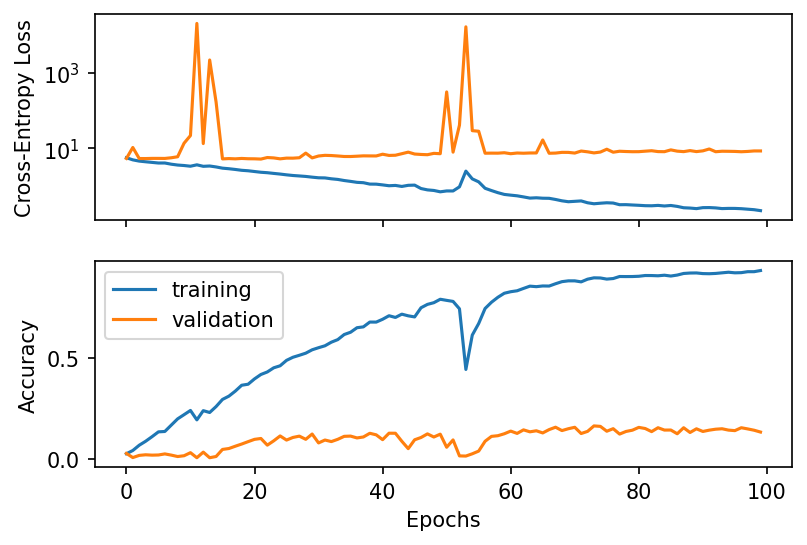

In [7]:
history = resnet_model.fit(train_generator,
                          steps_per_epoch=train_steps,# trained with 512
                          epochs=100,
                          validation_data=val_generator,
                          validation_steps=val_steps
                          )
plot_history(history)